<a href="https://colab.research.google.com/github/colingwuyu/HedgingBox/blob/master/gbm_call_env_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Projects/hb')

In [ ]:
#@title Install necessary dependencies.
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]


In [ ]:
#@title Import modules.
import copy

import acme
from acme import environment_loop
from acme import specs
from acme.tf import networks
from acme import types
from acme import wrappers
from acme.adders import reverb as adders
from acme.agents.tf import actors as actors
from acme.datasets import reverb as datasets
from acme.agents.tf import d4pg
from acme.agents import agent
from acme.tf import utils as tf2_utils
from acme.utils import loggers


from hb.bots import deltabot
from hb.market_env import bs_euro_hedge_env
import numpy as np
from typing import Dict, Sequence
import tensorflow as tf
import sonnet as snt
import matplotlib.pyplot as plt

import reverb

In [ ]:
environment = wrappers.SinglePrecisionWrapper(bs_euro_hedge_env.BSEuroHedgeEnv(
            episode_steps=30,
            option_maturity=30./365.,
            option_holding=-1_000,
            max_sell_action=-1_000,
            max_buy_action=1_000,
            trading_cost_pct=0.0,
    ))


PnL Mean: 39.25319770177205
PnL Std:  68.92717086074738


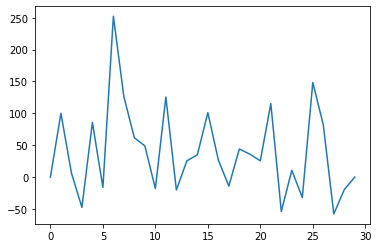

In [ ]:
actor = deltabot.DeltaHedgeActor(environment.action_spec())
num_episode = 1
for episode in range(num_episode):
    pnl = np.array([])
    timestep = environment.reset()

    while not timestep.last():
        action = actor.select_action(timestep.observation)
        # print(action)
        timestep = environment.step(action)
        pnl = np.append(pnl, timestep.reward)

    plt.plot(pnl)
    print('PnL Mean: %s' % str(np.mean(pnl)))
    print('PnL Std:  %s' % str(np.std(pnl)))


In [ ]:
def make_networks(
        action_spec: types.NestedSpec,
        policy_layer_sizes: Sequence[int] = (300, 200),
        critic_layer_sizes: Sequence[int] = (400, 300),
        vmin: float = -150.,
        vmax: float = 150.,
        num_atoms: int = 51,
) -> Dict[str, snt.Module]:
    """Creates networks used by the agent."""

    num_dimensions = np.prod(action_spec.shape, dtype=int)
    policy_layer_sizes = list(policy_layer_sizes) + [num_dimensions]

    policy_network = snt.Sequential(
        [networks.LayerNormMLP(policy_layer_sizes), tf.tanh])
    behavior_network = snt.Sequential(
        [networks.LayerNormMLP(policy_layer_sizes), tf.tanh] + 
        [networks.ClippedGaussian(0.3),
                      networks.ClipToSpec(action_spec)]
    )
    critic_network = snt.Sequential([
        networks.CriticMultiplexer(
            critic_network=networks.LayerNormMLP(
                critic_layer_sizes, activate_final=True)),
        networks.DiscreteValuedHead(vmin, vmax, num_atoms)
    ])

    return {
        'policy': policy_network,
        'behavior': behavior_network,
        'critic': critic_network,
    }


In [ ]:
environment_spec = specs.make_environment_spec(environment)
action_spec = environment_spec.actions

# Create the networks.
agent_networks = make_networks(environment_spec.actions)
policy_network = agent_networks['policy']
behavior_network = agent_networks['behavior']

In [ ]:
replay_buffer = reverb.Table(
    name=adders.DEFAULT_PRIORITY_TABLE,
    max_size=1000000,
    remover=reverb.selectors.Fifo(),
    sampler=reverb.selectors.Uniform(),
    rate_limiter=reverb.rate_limiters.MinSize(min_size_to_sample=1))

replay_server = reverb.Server([replay_buffer], port=None)
replay_server_address = 'localhost:%d' % replay_server.port

In [ ]:
adder = adders.NStepTransitionAdder(
    client=reverb.Client(replay_server_address),
    n_step=5,
    discount=0.99)

PnL Mean: 5.0399582862854
PnL Std:  303.83484256317


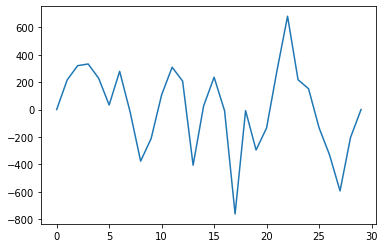

In [ ]:
actor = actors.FeedForwardActor(policy_network)
num_episode = 1
for episode in range(num_episode):
    pnl = np.array([])
    timestep = environment.reset()
    adder.add_first(timestep)

    while not timestep.last():
        action = actor.select_action(timestep.observation)
        timestep = environment.step(action)
        adder.add(action=action, next_timestep=timestep)
        pnl = np.append(pnl, timestep.reward)

    plt.plot(pnl)
    print('PnL Mean: %s' % str(np.mean(pnl)))
    print('PnL Std:  %s' % str(np.std(pnl)))

PnL Mean: -81.63808161417643
PnL Std:  733.0077200989441


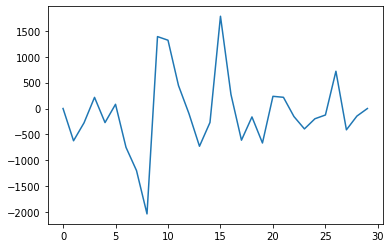

In [ ]:
actor = actors.FeedForwardActor(policy_network=behavior_network, adder=adder)
num_episode = 1

for episode in range(num_episode):
    pnl = np.array([])
    timestep = environment.reset()
    actor.observe_first(timestep)

    while not timestep.last():
        action = actor.select_action(timestep.observation)
        timestep = environment.step(action)
        actor.observe(action=action, next_timestep=timestep)
        pnl = np.append(pnl, timestep.reward)

    plt.plot(pnl)
    print('PnL Mean: %s' % str(np.mean(pnl)))
    print('PnL Std:  %s' % str(np.std(pnl)))

In [ ]:
dataset = datasets.make_dataset(
    client=reverb.TFClient(server_address=replay_server_address),
    batch_size=256,
    environment_spec=environment_spec,
    transition_adder=True)

In [ ]:
critic_network = agent_networks['critic']
# Create the target networks
target_policy_network = copy.deepcopy(policy_network)
target_critic_network = copy.deepcopy(critic_network)

# We must create the variables in the networks before passing them to learner.
tf2_utils.create_variables(network=policy_network,
                           input_spec=[environment_spec.observations])
tf2_utils.create_variables(network=critic_network,
                           input_spec=[environment_spec.observations,
                                       environment_spec.actions])
tf2_utils.create_variables(network=target_policy_network,
                           input_spec=[environment_spec.observations])
tf2_utils.create_variables(network=target_critic_network,
                           input_spec=[environment_spec.observations,
                                       environment_spec.actions])

In [ ]:
learner = d4pg.D4PGLearner(policy_network=policy_network,
                           critic_network=critic_network,
                           target_policy_network=target_policy_network,
                           target_critic_network=target_critic_network,
                           dataset=dataset,
                           discount=0.99,
                           target_update_period=100,
                           policy_optimizer=snt.optimizers.Adam(1e-4),
                           critic_optimizer=snt.optimizers.Adam(1e-4),
                           # Log learner updates to console every 10 seconds.
                           logger=loggers.TerminalLogger(time_delta=10.),
                           checkpoint=False)

In [ ]:
num_training_episodes =  10000 # @param {type: "integer"}
min_actor_steps_before_learning =   100# @param {type: "integer"}
num_actor_steps_per_iteration =   90 # @param {type: "integer"}
num_learner_steps_per_iteration = 1  # @param {type: "integer"}

learner_steps_taken = 0
actor_steps_taken = 0
for episode in range(num_training_episodes):
  
  timestep = environment.reset()
  actor.observe_first(timestep)
  episode_return = 0

  while not timestep.last():
    # Get an action from the agent and step in the environment.
    action = actor.select_action(timestep.observation)
    next_timestep = environment.step(action)

    # Record the transition.
    actor.observe(action=action, next_timestep=next_timestep)

    # Book-keeping.
    episode_return += next_timestep.reward
    actor_steps_taken += 1
    timestep = next_timestep

    # See if we have some learning to do.
    if (actor_steps_taken >= min_actor_steps_before_learning and
        actor_steps_taken % num_actor_steps_per_iteration == 0):
      # Learn.
      for learner_step in range(num_learner_steps_per_iteration):
        learner.step()
      learner_steps_taken += num_learner_steps_per_iteration

  # Log quantities.
  print('Episode: %d | Return: %f | Learner steps: %d | Actor steps: %d'%(
      episode, episode_return, learner_steps_taken, actor_steps_taken))

In [ ]:
d4pg_agent = agent.Agent(actor=actor,
                         learner=learner,
                         min_observations=256,
                         observations_per_step=8.)

In [ ]:
# Construct the agent.
d4pg_agent_one_stop = d4pg.D4PG(
    environment_spec=environment_spec,
    policy_network=agent_networks['policy'],
    critic_network=agent_networks['critic'],
    batch_size=256,
    samples_per_insert=32,
    min_replay_size=256,
)

In [ ]:
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
loop = acme.EnvironmentLoop(environment, d4pg_agent)
loop.run(num_episodes=1000)

Critic Loss = 3.571 | Policy Loss = 0.000 | Steps = 38 | Walltime = 463.016
[Environment Loop] Episode Length = 30 | Episode Return = -3927.419 | Episodes = 8 | Steps = 240 | Steps Per Second = 147.821
[Environment Loop] Episode Length = 30 | Episode Return = -3887.613 | Episodes = 13 | Steps = 390 | Steps Per Second = 138.920
[Environment Loop] Episode Length = 30 | Episode Return = -2333.605 | Episodes = 18 | Steps = 540 | Steps Per Second = 146.355
[Environment Loop] Episode Length = 30 | Episode Return = -8406.706 | Episodes = 24 | Steps = 720 | Steps Per Second = 147.208
[Environment Loop] Episode Length = 30 | Episode Return = -7529.027 | Episodes = 29 | Steps = 870 | Steps Per Second = 144.004
[Environment Loop] Episode Length = 30 | Episode Return = -5773.616 | Episodes = 35 | Steps = 1050 | Steps Per Second = 187.853
[Environment Loop] Episode Length = 30 | Episode Return = 2064.011 | Episodes = 41 | Steps = 1230 | Steps Per Second = 145.723
[Environment Loop] Episode Length =

In [ ]:
num_episode = 1
for episode in range(num_episode):
    pnl = np.array([])
    timestep = environment.reset()

    while not timestep.last():
        action = d4pg_agent.select_action(timestep.observation)
        print(action)
        timestep = environment.step(action)
        pnl = np.append(pnl, timestep.reward)

    plt.plot(pnl)
    print('PnL Mean: %s' % str(np.mean(pnl)))
    print('PnL Std:  %s' % str(np.std(pnl)))